<a href="https://colab.research.google.com/github/sayan0506/Face-Recognition-pipeline-using-SOTA-ArcFace/blob/main/Face_recognition_using_arcface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face recognition Pipeline design using arcface**

This notebook is inspired from the paper [ArcFace: Additive Angular Margin Loss for Deep Face Recognition](https://arxiv.org/pdf/1801.07698v3.pdf)

Git repo: [Insightface_Pytorch](https://github.com/TreB1eN/InsightFace_Pytorch)

**Install Dependencies**

In [1]:
# install tensorboardX
!pip install tensorboardX

     |████████████████████████████████| 122kB 6.7MB/s 


## **Mount Drive**

Drive: [link](hazrasayan2021@gmail.com)

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## **Import Dependencies**

In [3]:
from pathlib import Path
import numpy as np
import cv2
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# data pipeline
# helps to create dict where, use keys as atribute
from easydict import EasyDict as edict

from torchvision import transforms as trans
from torchvision.datasets import ImageFolder
from PIL import Image, ImageFile, ImageDraw
from torch.utils.data import Dataset, DataLoader

# ensures loading truncated images 
ImageFile.LOAD_TRUNCATED_IMAGES = True

# model build
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, Dropout2d, Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter
import torch.nn.functional as F
import torch
from collections import namedtuple
import math
import pdb

# model training
from tensorboardX import SummaryWriter
from torch import optim
from gdrive.MyDrive.arcface import model
from tqdm import tqdm
from torch.nn import CrossEntropyLoss

## **Environment Setup**

**Check GPU utilization**

In [4]:
#!export CUDA_VISIBLE_DEVICES=""

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

Running on device: cuda:0


In [6]:
print(f'Device info\n{torch.cuda.get_device_properties(0)}')

Device info
_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


## **Dataset Load and Train-Valid-Test**

Load the avengers face dataset
* Source: [Kaggle](https://www.kaggle.com/rawatjitesh/avengers-face-recognition)
* Drive link: [Dataset](https://drive.google.com/drive/folders/1VYuEXVOzUtd7fOaaLv7oW4YwGYbvh80w?usp=sharing)

**Defining Configuration Dictionary, which will contain the important metadata regarding the ML pipeline**

In [7]:
# config edict dictionary initialize
config = edict()

In [8]:
# configure device
config.device = device

In [9]:
# avengers face dataset path
dataset_path = "/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset"
# add dataset path to config
config.imgs_folder = dataset_path

#### **Data Analysis**

In [10]:
# identity list
identity_list = ['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson']
# identity path
identity_path = [os.path.join(config.imgs_folder, identity) for identity in identity_list]

print(f'Identity Paths\n{identity_path}')

Identity Paths
['/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/chris_evans', '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/chris_hemsworth', '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/mark_ruffalo', '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/robert_downey_jr', '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/scarlett_johansson']


**Define image and label dataframe for analysis**

In [11]:
# image dataframe
img_df = pd.DataFrame(columns = ['Image', 'Label'])

# label dataframe
label_df = pd.DataFrame(columns = identity_list)

**Fetching info**

In [12]:

print('\n[INFO] Loading images ...')
# total sample count
sample_count = 0
for sr, id_path in enumerate(identity_path):
  print(f'[INFO] Processing {identity_list[sr]}')
  sample_list = os.listdir(id_path)

  for id_sample in sample_list:
    # removing the .DS_store files from list, which contains the folder infos
    if id_sample == '.DS_store':
      sample_list.remove(id_sample)
  # categorical count
  count = 0
  for id_sample in sample_list:
    id_sample_path = os.path.join(id_path, id_sample)
    if id_sample_path.endswith(".jpg") == True or id_sample_path.endswith(".JPG") == True or id_sample_path.endswith(".png") == True or id_sample_path.endswith(".PNG") == True:
      img_df.loc[sample_count,'Image'], img_df.loc[sample_count,'Label'] = id_sample, identity_list[sr]
      #self.img_df.loc[sample_count,'Shape'] = img.shape
      count += 1
      sample_count += 1

  label_df.loc[0, identity_list[sr]] = count
  print(count)
  # checks whether all the samples are loaded successfully or not to img_df
  assert len(sample_list) == count

print(f'Data distribution of different identities\n{label_df}')
print(f'Image dataframe\n{img_df}')


[INFO] Loading images ...
[INFO] Processing chris_evans
50
[INFO] Processing chris_hemsworth
53
[INFO] Processing mark_ruffalo
66
[INFO] Processing robert_downey_jr
51
[INFO] Processing scarlett_johansson
54
Data distribution of different identities
  chris_evans chris_hemsworth mark_ruffalo robert_downey_jr scarlett_johansson
0          50              53           66               51                 54
Image dataframe
                        Image               Label
0           chris_evans34.png         chris_evans
1           chris_evans32.png         chris_evans
2            chris_evans6.png         chris_evans
3           chris_evans47.png         chris_evans
4           chris_evans13.png         chris_evans
..                        ...                 ...
269  scarlett_johansson54.png  scarlett_johansson
270  scarlett_johansson52.png  scarlett_johansson
271   scarlett_johansson9.png  scarlett_johansson
272  scarlett_johansson53.png  scarlett_johansson
273   scarlett_johansson5

**Target Distribution Visualize**

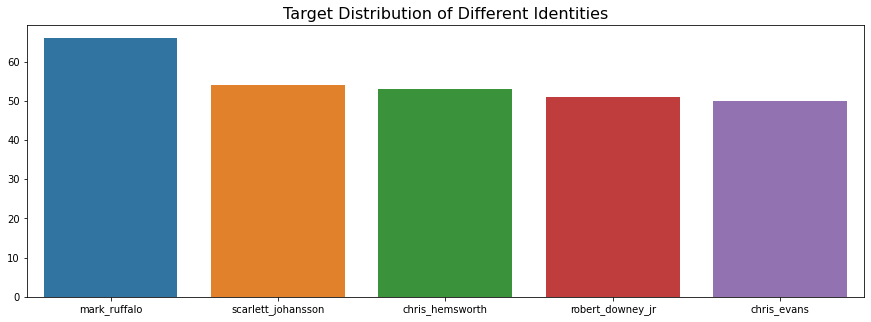

In [13]:
def distribution_vis(counts_series, label):
  '''
  Target distribution
  '''
  fig = plt.figure(figsize = (15,5))
  sns.barplot(x = counts_series.index, y = counts_series.values)
  plt.title(label, fontsize = 16)

# returns pandas series with classes as keys and count as values
target_counts = img_df['Label'].value_counts()

# vis distribution
distribution_vis(target_counts, label = 'Target Distribution of Different Identities')

#### **Train-Validation-Test Split**

We are taking train, valid, test ratio as - [0.9:0.05:0.05]

In [14]:
# validation split
val_ratio = 0.10
# test split
test_ratio = 0.5

# image_ids
img_ids = img_df.loc[:,'Image']

# image_ids
label_ids = img_df.loc[:,'Label']

**Defining train, validation, test dataframe**

In [15]:
# train df
train_df = pd.DataFrame(columns=['Image','Label'])
# validation main df
valid_main_df = pd.DataFrame(columns=['Image','Label'])
# validation df
valid_df = pd.DataFrame(columns=['Image','Label'])
# test df
test_df = pd.DataFrame(columns=['Image','Label'])

**Train-Valid_main Split**

In [16]:
train_df['Image'], valid_main_df['Image'], train_df['Label'], valid_main_df['Label'] = train_test_split(img_ids, label_ids,
                                                                                                      test_size = val_ratio,
                                                                                                      random_state = 28,
                                                                                                      stratify = label_ids,
                                                                                                      shuffle = True
                                                                                                      )

**Validation-Test Split**

In [17]:
valid_df['Image'], test_df['Image'], valid_df['Label'], test_df['Label'] = train_test_split(valid_main_df['Image'], valid_main_df['Label'],
                                                                                                      test_size = test_ratio,
                                                                                                      random_state = 28,
                                                                                                      stratify = valid_main_df['Label'],
                                                                                                      shuffle = True
                                                                                                      )

In [18]:
print(f'Train dataframe shape {train_df.shape}')
print(f'Validation dataframe shape {valid_df.shape}')
print(f'Test dataframe shape {test_df.shape}')

Train dataframe shape (246, 2)
Validation dataframe shape (14, 2)
Test dataframe shape (14, 2)


**STratification Check**

In [19]:
def distribution_vis_check(train, valid, test):
  '''
  Target distribution
  '''
  xdf = [train.index, valid.index, test.index]
  ydf = [train.values, valid.values, test.values]
  label = ['Train Distribution', 'Validation Distribution', 'Test Distribution'] 
  fig = plt.figure(figsize = (20,5))
  for i in range(len(xdf)):
    fig.add_subplot(1, len(xdf), i+1)
    sns.barplot(x = xdf[i], y = ydf[i])
    plt.xlabel(label[i], fontsize = 16)


**Startifiction check using the df**

In [20]:
print(train_df['Label'].value_counts())
print(valid_df['Label'].value_counts())
print(test_df['Label'].value_counts())

mark_ruffalo          59
scarlett_johansson    48
chris_hemsworth       48
robert_downey_jr      46
chris_evans           45
Name: Label, dtype: int64
mark_ruffalo          4
chris_evans           3
scarlett_johansson    3
chris_hemsworth       2
robert_downey_jr      2
Name: Label, dtype: int64
mark_ruffalo          3
chris_hemsworth       3
robert_downey_jr      3
scarlett_johansson    3
chris_evans           2
Name: Label, dtype: int64


**Startification CHek Visualize**

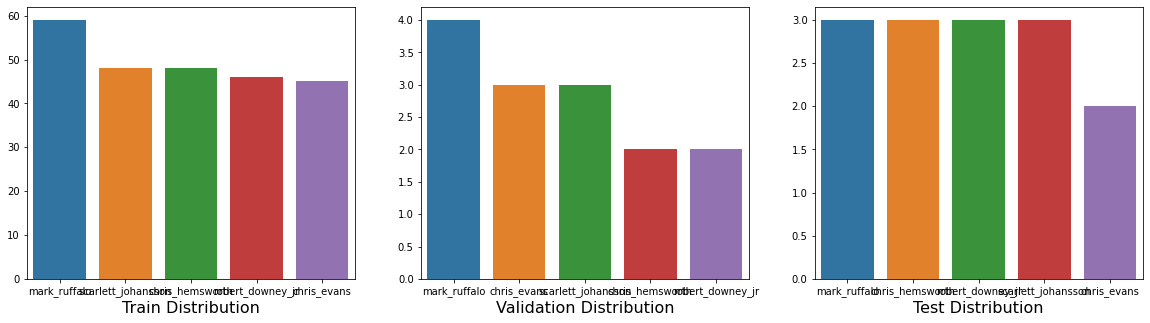

In [21]:
distribution_vis_check(train_df['Label'].value_counts(), valid_df['Label'].value_counts(), test_df['Label'].value_counts())

**From all the above analysis, the data train-valid-test split is stratified**

#### **Face Extraction**

For face detection in the images we are using pre-trained Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks.

[Reference paper](https://arxiv.org/abs/1604.02878)

Git clone facenet_pytorch, which consists MTCNN face detector

[Git repo](https://github.com/timesler/facenet-pytorch)



In [22]:
!git clone https://github.com/timesler/facenet-pytorch

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1264, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 1264 (delta 11), reused 8 (delta 2), pack-reused 1235
Receiving objects: 100% (1264/1264), 22.89 MiB | 44.39 MiB/s, done.
Resolving deltas: 100% (613/613), done.


**Rename folder to "facenet_pytorch", as python module does not accept name containing "-"**

In [23]:
os.rename('facenet-pytorch', 'facenet_pytorch')

**Import Dependencies for MTCNN face detector**

In [24]:
from facenet_pytorch.models.mtcnn import MTCNN

**Define MTCNN module**

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

In [25]:
# face detector object
# using default reshaped face size = (160,160)
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=config.device
)

**Demo Detection**

face count in the sample is 1 with confidence 99.45905208587646%

Done Detection


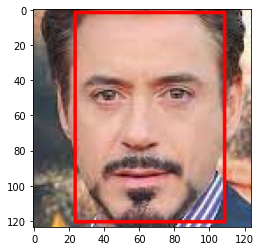

In [26]:
sample_img = 'robert_downey_jr9.png' 

# read using PIL library, else ImagDraw will not work here
img = Image.open(os.path.join(config.imgs_folder, 'robert_downey_jr', sample_img))

# detect faces
boxes, prob = mtcnn.detect(img)

# draw faces
img_draw = img.copy()

# define draw object to draw on the image
draw = ImageDraw.Draw(img_draw)
for box in boxes:
  draw.rectangle(box.tolist(), outline = (255,0,0), width = 2)
print(f'face count in the sample is {len(boxes)} with confidence {prob[0]*100}%')

print('\nDone Detection')

plt.imshow(img_draw)
plt.show()

## **Create Torch Dataset**

**Configure input image size**

In [27]:
config.input_size = (112,112)

**Define custom FcaeDataset class to obtain samples from train, valid, test dataframe**

In [28]:
class FaceDataset(Dataset):
  def __init__(self, df, root_dir, identity_list, transform = None):
    self.df = df
    self.dir = root_dir
    self.transform = transform
    self.identity = identity_list
  
  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    img_name = os.path.join(self.dir, self.df['Label'].iloc[idx], self.df['Image'].iloc[idx])
    sample = [Image.open(img_name), int(self.identity.index(self.df['Label'].iloc[idx]))]

    if self.transform:
      sample[0] = self.transform(sample[0])
    
    sample = tuple(sample)

    return sample


**Configure Identity list, train_dataframe, valid_dataframe, test_dataframe**

In [29]:
config.identity = identity_list
config.train_df = train_df
config.valid_df = valid_df
config.test_df = test_df

**Define and configure transform for train, valid, test**

Define same transform for train, valid, test using torcgvision transform

In [30]:
# configure transform
config.transform = trans.Compose([
                                   trans.RandomHorizontalFlip(), # random horizonttal flip of faces
                                   trans.ToTensor(), # convert img to torch tensor
                                   trans.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]), # normalize
                                   trans.Resize(config.input_size, interpolation=trans.InterpolationMode.BICUBIC)
  ])

**Create train dataset from the train dataframe**

In [31]:
def get_dataset(config, df):
  # fetch and transform the images using torchvision transforms to create dataset
  # from the image folder
  ds = FaceDataset(df, config.imgs_folder, config.identity, transform= config.transform)
  class_num = len(config.identity) # total class is the index of last folder + 1
  return ds, class_num

# create train dataset
train_ds, train_class_num = get_dataset(config, config.train_df)

In [32]:
targets = [train_ds.identity.index(id) for id in train_ds.identity]

In [33]:
print(f'Train Dataset info {train_ds},\ncontains {train_class_num} different identities!')
print(f'Classes available in the dataset \n{train_ds.identity},\nhaving class ids {targets} respectively!')
print(f'Length of the dataset {len(train_ds)}')

Train Dataset info <__main__.FaceDataset object at 0x7fe679113450>,
contains 5 different identities!
Classes available in the dataset 
['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson'],
having class ids [0, 1, 2, 3, 4] respectively!
Length of the dataset 246


**Create validation dataset from the validation dataframe**

In [34]:
# create validation dataset
valid_ds, valid_class_num = get_dataset(config, config.valid_df)

In [35]:
print(f'Validation Dataset info {valid_ds},\ncontains {valid_class_num} different identities!')
print(f'Classes available in the dataset \n{valid_ds.identity},\nhaving class ids {targets} respectively!')
print(f'Length of the dataset {len(valid_ds)}')

Validation Dataset info <__main__.FaceDataset object at 0x7fe678e1dd10>,
contains 5 different identities!
Classes available in the dataset 
['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson'],
having class ids [0, 1, 2, 3, 4] respectively!
Length of the dataset 14


**Create test dataset from the validation dataframe**

In [36]:
# create test dataset
test_ds, test_class_num = get_dataset(config, config.test_df)

In [37]:
print(f'Test Dataset info {test_ds},\ncontains {test_class_num} different identities!')
print(f'Classes available in the dataset \n{test_ds.identity},\nhaving class ids {targets} respectively!')
print(f'Length of the dataset {len(test_ds)}')

Test Dataset info <__main__.FaceDataset object at 0x7fe678e0b310>,
contains 5 different identities!
Classes available in the dataset 
['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson'],
having class ids [0, 1, 2, 3, 4] respectively!
Length of the dataset 14


#### **Define Pytorch DataLoader**

Define the data_loader function, where we can pass dataset mode(as 'vgg' or 'ms1m') through configuration dictionary.


In [38]:
# define the train_loader function, where we can pass dataset mode(as 'vgg' or 'ms1m') through configuration dictionary
def get_data_loader(ds, class_num, config):
  if config.data_mode in ['ms1m','vgg']:
    # create train_loader, by deafult shuffles the datapoints
    data_loader = DataLoader(ds, batch_size=config.batch_size, shuffle = True, pin_memory = config.pin_memory,
                              num_workers = config.num_workers)
    return data_loader, class_num

**Defining metadata parameters to config**

In [39]:
# initializing data_mode as 'ms1m' dataset
config.data_mode = 'ms1m'
# initializing batch_size to 64
config.batch_size = 64
# pin_memory status is set to True, which enables to load samples of data to device(GPU), spped-up the training
config.pin_memory = True
# initializing the number of workers to 3
config.num_workers = 3

**Create the train dataloader**

In [40]:
train_loader, _ = get_data_loader(train_ds, train_class_num, config)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Create the validation dataloader**

In [41]:
valid_loader, _ = get_data_loader(valid_ds, valid_class_num, config)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**Create the test dataloader**

In [42]:
test_loader, _ = get_data_loader(test_ds, test_class_num, config)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## **ArcFace Model Build**

There are Backbone, Mobilefacenet models for generating face embedding. But, We are considering to use only Mobilefacenet, as it's a light-weight model.

**Define Flatten Block**

In [43]:
# flatten block
class Flatten(Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

**Define L2_norm block**

In [44]:
def l2_norm(input, axis = 1):
  norm = torch.norm(input, 2, axis, True)
  output = torch.div(input, norm)
  return output

**Define a Convolution Block**

In [45]:
# defining torch deafult sub-class api
# PReLU - Parameterized ReLU used to handle the variations(parameterize activation @ x< 0) in lower level layers 
class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)
    
    # forward prop
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

**Define Linear Block**

In [46]:
class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

**Define Depthwise Seperable Convolution Block**

In [47]:
class Depth_Wise(Module):
     def __init__(self, in_c, out_c, residual = False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = Conv_block(groups, groups, groups=groups, kernel=kernel, padding=padding, stride=stride)
        self.project = Linear_block(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual
     def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output

**Define Residual Block**

In [48]:
class Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(Depth_Wise(c, c, residual=True, kernel=kernel, padding=padding, stride=stride, groups=groups))
        self.model = Sequential(*modules)
    def forward(self, x):
        return self.model(x)


**Define the embedding-size in the config**

In [49]:
config.embedding_size = 512

#### **Define Mobilefacenet Model**

In [50]:
class MobileFaceNet(Module):
    def __init__(self, embedding_size):
        super(MobileFaceNet, self).__init__()
        self.conv1 = Conv_block(3, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2_dw = Conv_block(64, 64, kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        self.conv_23 = Depth_Wise(64, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=128)
        self.conv_3 = Residual(64, num_block=4, groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_34 = Depth_Wise(64, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=256)
        self.conv_4 = Residual(128, num_block=6, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_45 = Depth_Wise(128, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=512)
        self.conv_5 = Residual(128, num_block=2, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_6_sep = Conv_block(128, 512, kernel=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups=512, kernel=(7,7), stride=(1, 1), padding=(0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias=False)
        self.bn = BatchNorm1d(embedding_size)
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2_dw(out)

        out = self.conv_23(out)

        out = self.conv_3(out)
        
        out = self.conv_34(out)

        out = self.conv_4(out)

        out = self.conv_45(out)

        out = self.conv_5(out)

        out = self.conv_6_sep(out)

        out = self.conv_6_dw(out)

        out = self.conv_6_flatten(out)

        out = self.linear(out)

        out = self.bn(out)
        return l2_norm(out)

**Initialize the Mobilefacenet model**

In [51]:
# call model object
mobilefacenet_model = model.MobileFaceNet(embedding_size= config.embedding_size).to(config.device)

#print(f'Model summary:\n{mobilefacenet_model}')

#### **Define Arcface Head**

Implementation of **additive margin softmax** loss in https://arxiv.org/abs/1801.05599

In [52]:
class Arcface(Module):
    # implementation of additive margin softmax loss in https://arxiv.org/abs/1801.05599
    # total class is set to deafult as the original dataset    
    def __init__(self, embedding_size=512, classnum=51332,  s=64., m=0.5):
        super(Arcface, self).__init__()
        self.classnum = classnum
        self.kernel = Parameter(torch.Tensor(embedding_size,classnum))
        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m # the margin value, default is 0.5
        self.s = s # scalar value default is 64, see normface https://arxiv.org/abs/1704.06369
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.mm = self.sin_m * m  # issue 1
        self.threshold = math.cos(math.pi - m)
    def forward(self, embbedings, label):
        # weights norm
        nB = len(embbedings)
        kernel_norm = l2_norm(self.kernel,axis=0)
        # cos(theta+m)
        cos_theta = torch.mm(embbedings,kernel_norm)
#         output = torch.mm(embbedings,kernel_norm)
        cos_theta = cos_theta.clamp(-1,1) # for numerical stability
        cos_theta_2 = torch.pow(cos_theta, 2)
        sin_theta_2 = 1 - cos_theta_2
        sin_theta = torch.sqrt(sin_theta_2)
        cos_theta_m = (cos_theta * self.cos_m - sin_theta * self.sin_m)
        # this condition controls the theta+m should in range [0, pi]
        #      0<=theta+m<=pi
        #     -m<=theta<=pi-m
        cond_v = cos_theta - self.threshold
        cond_mask = cond_v <= 0
        keep_val = (cos_theta - self.mm) # when theta not in [0,pi], use cosface instead
        cos_theta_m[cond_mask] = keep_val[cond_mask]
        output = cos_theta * 1.0 # a little bit hacky way to prevent in_place operation on cos_theta
        idx_ = torch.arange(0, nB, dtype=torch.long)
        output[idx_, label] = cos_theta_m[idx_, label]
        output *= self.s # scale up in order to make softmax work, first introduced in normface
        return output

## **Model Training**

**Define to read bin of parameters**

In [53]:
def seperate_bn_paras(modules):
  # if modules is not object or instantiated
  if not isinstance(modules, list):
    modules = [*modules.modules()]
  paras_only_bn = []
  paras_wo_bn = []
  for layer in modules:
    if 'model' in str(layer.__class__):
      continue
    if 'container' in str(layer.__class__):
      continue
    else:
      if 'batchnorm' in str(layer.__class__):
        # takes bin of parameters
        paras_only_bn.extend([*layer.parameters()])
      else:
        paras_wo_bn.extend([*layer.parameters()])
  return paras_only_bn, paras_wo_bn


**Configure saved model path**

In [54]:
config.save_path = 'saved_model'

if not os.path.isdir(config.save_path):
  os.mkdir(config.save_path)

**Initialize training and define training parameters**

In [55]:
class face_learner(object):
  def __init__(self, config, model, train_loader, train_class_num, inference = False):
    print(f'Configureation-\n{config}')
    # if we want to load MobileFcaenet model
    if config.use_mobilefacenet:
      # model already loaded to device
      self.model = model
      print('MobilefaceNet model generated!')
    else:
      print('Load the different model!')
    
    # defines the milestones where, the lr_scheduler will act
    self.milestones = config.milestones
    self.val_loader, self.val_class_num = valid_loader, valid_class_num
    self.loader, self.class_num = train_loader, train_class_num

    # helps to log summary of training using TensorboardX
    #self.writer = SummaryWriter(config.log_path)
    self.step = 0
    self.head = Arcface(embedding_size=config.embedding_size, classnum=self.class_num).to(device)

    print('Two model heads generated!')

    paras_only_bn, paras_wo_bn = seperate_bn_paras(self.model)   
    #print(len(paras_only_bn))
    #print(len(paras_wo_bn))
    # define optimizer for mobilefacenet
    if config.use_mobilefacenet:
      self.optimizer = optim.SGD([
                                  {'params': paras_wo_bn[:-1], 'weight_decay': 4e-05},# weight decay for the params
                                  {'params': [paras_wo_bn[-1]] + [self.head.kernel], 'weight_decay': 4e-04},
                                  {'params': paras_only_bn}
      ], lr = config.lr, momentum = config.momentum)
    
    else:
      self.optimizer = optim.SGD([
                                  {'params': paras_wo_bn + [self.head.kernel], 'weight_decay': 5e-04},
                                  {'params': paras_only_bn}
      ], lr = config.lr, momentum = config.momentum)
  
    print(self.optimizer)
    
    print('Optimizers generated')
    # log loss to every (len of loader//100) step
    self.board_loss_every = len(self.loader)//100
    # evaluate every (len of loader//10) step
    self.evaluate_every = len(self.loader)//10
    # save after (len(loader)//5) step
    self.save_every = len(self.loader)//5
    
  # lr scheduler
  def schedule_lr(self):
    for params in self.optimizer.param_groups:
      params['lr']/=10
    print(self.optimizer)

  # save state of the model
  def save_state(self, config, loss, model_only = False):
    # save to model to config path
    save_path = config.save_path

    torch.save(
        self.model.state_dict(), os.path.join(save_path, 
        f'model_step_{self.step}_loss_{loss}.path'))
    
    if not model_only:
      torch.save(
          self.head.state_dict(), os.path.join(save_path, f'head_step_{self.step}_loss_{loss}.path')
      )

      torch.save(
          self.optimizer.state_dict(), os.path.join(save_path,
                                                    f'optimizer_step_{self.step}_loss_{loss}.path')
      )
  
    self.save_validated_model = tuple([os.path.join(save_path, f'model_step_{self.step}_loss_{loss}.path'),
                             os.path.join(save_path, f'head_step_{self.step}_loss_{loss}.path'),
                             os.path.join(save_path, f'optimizer_step_{self.step}_loss_{loss}.path')])

  # load the state from saved model
  def load_state(self, config, fixed_str, from_save_folder = False, model_only = False):
    if from_save_folder:
      load_save_path = config.pretrained_save_path
    else:
      load_save_path = config.model_path
    self.model.load_state_dict(torch.load(os.path.join(load_save_path,'model_{}'.format(fixed_str))))
    if not model_only:
      self.head.load_state_dict(torch.load(os.path.join(load_save_path,'head_{}'.format(fixed_str))))
      self.optimizer.load_state_dict(torch.load(os.path.join(load_save_path,'optimizer_{}'.format(fixed_str))))


**Configure metadata for training**

In [56]:
# define work_space 
config.work_path = Path('work_space/')

# create work_space path, if not existed
if not os.path.isdir(config.work_path):
  os.mkdir(config.work_path)

# configure logpath
config.log_path = config.work_path/'log'

# create log path, if not existed
#if not os.path.isdir(config.work_path/'log'):
#  os.mkdir(config.work_path/'log')

# configure mobilefacenet status
config.use_mobilefacenet = True

# configure milestones
config.milestones = [12,15,18]

# configure momentum
config.momentum = 0.9

# configure learning rate
config.lr = 1e-03

# loss fn
config.ce_loss = CrossEntropyLoss()

**Configure pre-trained model path**

In [57]:
# mobilefacenet load model path
config.pretrained_save_path = '/content'

#### **Define Model Train**

In [68]:
def train(config, epochs):
  learner = face_learner(config, mobilefacenet_model, train_loader, train_class_num)
  # load the mobilefacenet model
  learner.load_state(config, 'mobilefacenet.pth', from_save_folder = True, model_only = True)
  print('Mobilenet pre-trained loaded successfully!')
  learner.model.train()
  running_loss = 0
  # stores loss of each step
  loss_bank = []
  for e in range(epochs):
    print('epoch {} started'.format(e))
    # at each milestone learning rate is changes according to the scheduler
    if e == learner.milestones[0]:
        learner.schedule_lr()
    if e == learner.milestones[1]:
        learner.schedule_lr()      
    if e == learner.milestones[2]:
        learner.schedule_lr()                                 
    
    for imgs, labels in tqdm(iter(learner.loader)):
        imgs = imgs.to(config.device)
        labels = labels.to(config.device)
        learner.optimizer.zero_grad()
        embeddings = learner.model(imgs)
        thetas = learner.head(embeddings, labels)
        loss = config.ce_loss(thetas, labels)
        loss.backward()
        running_loss += loss.item()
        learner.optimizer.step()
        learner.step += 1
        print(f'Train Loss of step {learner.step} is  {loss}')
        
        val_loss = 0
        # create validation loss
        for val_imgs, val_labels in tqdm(iter(learner.val_loader)):
          val_imgs = val_imgs.to(config.device)
          val_labels = val_labels.to(config.device)
          learner.optimizer.zero_grad()
          val_embeddings = learner.model(val_imgs)
          val_thetas = learner.head(val_embeddings, val_labels)
          val_loss += config.ce_loss(val_thetas, val_labels)
          
        print(f'Validation Loss of step {learner.step} is {val_loss}')

        if len(loss_bank):
          if loss_bank[-1]>val_loss:
            learner.save_state(config, val_loss)
            print(f'Saving model at epoch {e}, step {learner.step}') 
            loss_bank = [] 
            
            # if current validation loss is min, then store it, else don't store
            loss_bank.append(val_loss)

        else:
          loss_bank.append(val_loss)

  print(f'\nMin validation loss - {loss_bank[0]}')    
  print(f'\nBest model based on validation data result - {learner.save_validated_model}')
  config.best_model = learner.save_validated_model            
        

**Model Training**

In [66]:
train(config, epochs = 20)

Configureation-
{'device': device(type='cuda', index=0), 'imgs_folder': '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset', 'input_size': [112, 112], 'identity': ['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson'], 'train_df':                         Image               Label
46          chris_evans24.png         chris_evans
242   scarlett_johansson4.png  scarlett_johansson
224  scarlett_johansson23.png  scarlett_johansson
188     robert_downey_jr5.png    robert_downey_jr
260  scarlett_johansson24.png  scarlett_johansson
..                        ...                 ...
49           chris_evans4.png         chris_evans
184    robert_downey_jr37.png    robert_downey_jr
17          chris_evans14.png         chris_evans
218     robert_downey_jr7.png    robert_downey_jr
147        mark_ruffalo47.png        mark_ruffalo

[246 rows x 2 columns], 'valid_df':                         Image               Label
5           chris_ev

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 1 is  34.53255844116211



 25%|██▌       | 1/4 [00:18<00:55, 18.44s/it]

Validation Loss of step 1 is 32.5806999206543
Train Loss of step 2 is  33.21546936035156



 50%|█████     | 2/4 [00:18<00:26, 13.06s/it]

Validation Loss of step 2 is 31.112516403198242
Saving model at epoch 0, step 2
Train Loss of step 3 is  31.451507568359375



 75%|███████▌  | 3/4 [00:19<00:09,  9.29s/it]

Validation Loss of step 3 is 29.18086814880371
Saving model at epoch 0, step 3
Train Loss of step 4 is  29.91007423400879



100%|██████████| 4/4 [00:33<00:00,  8.26s/it]

Validation Loss of step 4 is 26.2310733795166
Saving model at epoch 0, step 4
epoch 1 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 5 is  25.6253662109375



 25%|██▌       | 1/4 [00:01<00:05,  1.93s/it]

Validation Loss of step 5 is 23.758190155029297
Saving model at epoch 1, step 5
Train Loss of step 6 is  22.518232345581055



 50%|█████     | 2/4 [00:02<00:02,  1.49s/it]

Validation Loss of step 6 is 20.229122161865234
Saving model at epoch 1, step 6
Train Loss of step 7 is  18.701461791992188



 75%|███████▌  | 3/4 [00:02<00:01,  1.20s/it]

Validation Loss of step 7 is 17.51957893371582
Saving model at epoch 1, step 7
Train Loss of step 8 is  15.340415954589844



100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

Validation Loss of step 8 is 14.080931663513184
Saving model at epoch 1, step 8
epoch 2 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 9 is  10.635951042175293



 25%|██▌       | 1/4 [00:01<00:05,  1.93s/it]

Validation Loss of step 9 is 11.62201976776123
Saving model at epoch 2, step 9
Train Loss of step 10 is  7.53221321105957



 50%|█████     | 2/4 [00:02<00:02,  1.49s/it]

Validation Loss of step 10 is 9.574736595153809
Saving model at epoch 2, step 10
Train Loss of step 11 is  5.775552749633789



 75%|███████▌  | 3/4 [00:02<00:01,  1.19s/it]

Validation Loss of step 11 is 7.400628089904785
Saving model at epoch 2, step 11
Train Loss of step 12 is  5.832921981811523



100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

Validation Loss of step 12 is 5.973239421844482
Saving model at epoch 2, step 12
epoch 3 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 13 is  3.3592634201049805



 25%|██▌       | 1/4 [00:01<00:05,  1.80s/it]

Validation Loss of step 13 is 6.370728492736816
Train Loss of step 14 is  1.5662565231323242



 50%|█████     | 2/4 [00:02<00:02,  1.44s/it]

Validation Loss of step 14 is 3.914362668991089
Saving model at epoch 3, step 14
Train Loss of step 15 is  1.363006830215454



 75%|███████▌  | 3/4 [00:02<00:01,  1.15s/it]

Validation Loss of step 15 is 2.9691498279571533
Saving model at epoch 3, step 15
Train Loss of step 16 is  0.6753172278404236



100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

Validation Loss of step 16 is 3.3387210369110107
epoch 4 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 17 is  0.5993761420249939



 25%|██▌       | 1/4 [00:02<00:06,  2.00s/it]

Validation Loss of step 17 is 2.5418717861175537
Saving model at epoch 4, step 17
Train Loss of step 18 is  0.5183834433555603



 50%|█████     | 2/4 [00:02<00:03,  1.55s/it]

Validation Loss of step 18 is 2.5224077701568604
Saving model at epoch 4, step 18
Train Loss of step 19 is  0.9798662066459656



 75%|███████▌  | 3/4 [00:02<00:01,  1.22s/it]

Validation Loss of step 19 is 1.9279016256332397
Saving model at epoch 4, step 19
Train Loss of step 20 is  0.35764065384864807



100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

Validation Loss of step 20 is 2.9348530769348145
epoch 5 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 21 is  0.0025354628451168537



 25%|██▌       | 1/4 [00:01<00:05,  1.94s/it]

Validation Loss of step 21 is 2.38371205329895
Train Loss of step 22 is  0.11629508435726166



 50%|█████     | 2/4 [00:02<00:02,  1.49s/it]

Validation Loss of step 22 is 1.6075748205184937
Saving model at epoch 5, step 22
Train Loss of step 23 is  0.06460989266633987



 75%|███████▌  | 3/4 [00:02<00:01,  1.19s/it]

Validation Loss of step 23 is 1.1874479055404663
Saving model at epoch 5, step 23
Train Loss of step 24 is  0.4584815502166748



100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

Validation Loss of step 24 is 1.9914480447769165
epoch 6 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 25 is  0.06997811794281006



 25%|██▌       | 1/4 [00:01<00:05,  2.00s/it]

Validation Loss of step 25 is 1.3906126022338867
Train Loss of step 26 is  0.04211460053920746



 50%|█████     | 2/4 [00:02<00:03,  1.53s/it]

Validation Loss of step 26 is 1.487074613571167
Train Loss of step 27 is  0.000891093397513032



 75%|███████▌  | 3/4 [00:02<00:01,  1.20s/it]

Validation Loss of step 27 is 1.4849441051483154
Train Loss of step 28 is  0.27494075894355774



100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

Validation Loss of step 28 is 1.724923849105835
epoch 7 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 29 is  4.1682651499286294e-05



 25%|██▌       | 1/4 [00:01<00:05,  1.99s/it]

Validation Loss of step 29 is 0.6072013974189758
Saving model at epoch 7, step 29
Train Loss of step 30 is  0.0036591696552932262



 50%|█████     | 2/4 [00:02<00:03,  1.52s/it]

Validation Loss of step 30 is 1.8606529235839844
Train Loss of step 31 is  0.1250867247581482



 75%|███████▌  | 3/4 [00:02<00:01,  1.19s/it]

Validation Loss of step 31 is 0.6308210492134094
Train Loss of step 32 is  0.0002576765837147832



100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

Validation Loss of step 32 is 1.7667683362960815
epoch 8 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 33 is  0.03700356185436249



 25%|██▌       | 1/4 [00:01<00:05,  1.71s/it]

Validation Loss of step 33 is 1.6814314126968384
Train Loss of step 34 is  1.2255948149686446e-06



 50%|█████     | 2/4 [00:02<00:02,  1.38s/it]

Validation Loss of step 34 is 0.42632824182510376
Saving model at epoch 8, step 34
Train Loss of step 35 is  1.0594922059681267e-05



 75%|███████▌  | 3/4 [00:02<00:01,  1.09s/it]

Validation Loss of step 35 is 0.8536733388900757
Train Loss of step 36 is  3.377586210717709e-07



100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

Validation Loss of step 36 is 1.2986031770706177
epoch 9 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 37 is  0.04245641082525253



 25%|██▌       | 1/4 [00:01<00:05,  1.82s/it]

Validation Loss of step 37 is 0.4866894781589508
Train Loss of step 38 is  0.0003908751532435417



 50%|█████     | 2/4 [00:02<00:02,  1.41s/it]

Validation Loss of step 38 is 0.7436680197715759
Train Loss of step 39 is  7.077906047925353e-07



 75%|███████▌  | 3/4 [00:02<00:01,  1.11s/it]

Validation Loss of step 39 is 2.252817392349243
Train Loss of step 40 is  3.954668136429973e-05



100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

Validation Loss of step 40 is 0.9423857927322388
epoch 10 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 41 is  8.890220669854898e-06



 25%|██▌       | 1/4 [00:01<00:05,  1.86s/it]

Validation Loss of step 41 is 1.7219734191894531
Train Loss of step 42 is  0.0006789066828787327



 50%|█████     | 2/4 [00:02<00:02,  1.44s/it]

Validation Loss of step 42 is 0.4778316915035248
Train Loss of step 43 is  0.04233480244874954



 75%|███████▌  | 3/4 [00:02<00:01,  1.14s/it]

Validation Loss of step 43 is 1.175379991531372
Train Loss of step 44 is  1.3117370144755114e-05



100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

Validation Loss of step 44 is 0.6572645902633667
epoch 11 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 45 is  0.12732365727424622



 25%|██▌       | 1/4 [00:01<00:05,  1.78s/it]

Validation Loss of step 45 is 0.5131180286407471
Train Loss of step 46 is  0.0005540685961022973



 50%|█████     | 2/4 [00:02<00:02,  1.39s/it]

Validation Loss of step 46 is 0.7074950933456421
Train Loss of step 47 is  1.5701768916187575e-06



 75%|███████▌  | 3/4 [00:02<00:01,  1.10s/it]

Validation Loss of step 47 is 1.5750625133514404
Train Loss of step 48 is  0.0009979763999581337



100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

Validation Loss of step 48 is 1.4334392547607422
epoch 12 started
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 4e-05

Parameter Group 1
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0004

Parameter Group 2
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 49 is  0.17662394046783447



 25%|██▌       | 1/4 [00:01<00:05,  1.94s/it]

Validation Loss of step 49 is 0.6702814698219299
Train Loss of step 50 is  0.013297409750521183



 50%|█████     | 2/4 [00:02<00:02,  1.49s/it]

Validation Loss of step 50 is 1.5024107694625854
Train Loss of step 51 is  1.154988603957463e-05



 75%|███████▌  | 3/4 [00:02<00:01,  1.17s/it]

Validation Loss of step 51 is 1.588944435119629
Train Loss of step 52 is  2.8698434562102193e-07



100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

Validation Loss of step 52 is 0.6864823698997498
epoch 13 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 53 is  8.687849185662344e-05



 25%|██▌       | 1/4 [00:01<00:05,  1.82s/it]

Validation Loss of step 53 is 0.8235654830932617
Train Loss of step 54 is  0.0004321700253058225



 50%|█████     | 2/4 [00:02<00:02,  1.44s/it]

Validation Loss of step 54 is 0.32615312933921814
Saving model at epoch 13, step 54
Train Loss of step 55 is  4.474678644328378e-05



 75%|███████▌  | 3/4 [00:02<00:01,  1.13s/it]

Validation Loss of step 55 is 2.0100553035736084
Train Loss of step 56 is  6.471505002991762e-06



100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

Validation Loss of step 56 is 1.4092695713043213
epoch 14 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 57 is  1.2460882317100186e-06



 25%|██▌       | 1/4 [00:01<00:05,  1.97s/it]

Validation Loss of step 57 is 1.5913658142089844
Train Loss of step 58 is  0.0002719182812143117



 50%|█████     | 2/4 [00:02<00:03,  1.51s/it]

Validation Loss of step 58 is 1.6403446197509766
Train Loss of step 59 is  0.00024463506997562945



 75%|███████▌  | 3/4 [00:02<00:01,  1.18s/it]

Validation Loss of step 59 is 1.158493161201477
Train Loss of step 60 is  0.006615769118070602



100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

Validation Loss of step 60 is 1.8062480688095093
epoch 15 started
SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0.9
    nesterov: False
    weight_decay: 4e-05

Parameter Group 1
    dampening: 0
    lr: 1e-05
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0004

Parameter Group 2
    dampening: 0
    lr: 1e-05
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 61 is  4.50464322057087e-05



 25%|██▌       | 1/4 [00:01<00:05,  1.78s/it]

Validation Loss of step 61 is 0.6355973482131958
Train Loss of step 62 is  0.00015528890071436763



 50%|█████     | 2/4 [00:02<00:02,  1.41s/it]

Validation Loss of step 62 is 1.160771131515503
Train Loss of step 63 is  1.9780040929617826e-06



 75%|███████▌  | 3/4 [00:02<00:01,  1.11s/it]

Validation Loss of step 63 is 1.4575191736221313
Train Loss of step 64 is  3.7261543184285983e-06



100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

Validation Loss of step 64 is 0.9759466052055359
epoch 16 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 65 is  0.04980463907122612



 25%|██▌       | 1/4 [00:01<00:05,  1.82s/it]

Validation Loss of step 65 is 0.8663520812988281
Train Loss of step 66 is  2.9259574603202054e-06



 50%|█████     | 2/4 [00:02<00:02,  1.41s/it]

Validation Loss of step 66 is 0.9948189854621887
Train Loss of step 67 is  2.458677386130148e-07



 75%|███████▌  | 3/4 [00:02<00:01,  1.12s/it]

Validation Loss of step 67 is 1.2222957611083984
Train Loss of step 68 is  0.00804489478468895



100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

Validation Loss of step 68 is 1.8900963068008423
epoch 17 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 69 is  3.9660932088736445e-05



 25%|██▌       | 1/4 [00:01<00:05,  1.91s/it]

Validation Loss of step 69 is 2.2310404777526855
Train Loss of step 70 is  1.456567019886279e-06



 50%|█████     | 2/4 [00:02<00:02,  1.47s/it]

Validation Loss of step 70 is 1.9027248620986938
Train Loss of step 71 is  1.2162784059910337e-06



 75%|███████▌  | 3/4 [00:02<00:01,  1.16s/it]

Validation Loss of step 71 is 0.6583355069160461
Train Loss of step 72 is  0.016132976859807968



100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

Validation Loss of step 72 is 1.9752362966537476
epoch 18 started
SGD (
Parameter Group 0
    dampening: 0
    lr: 1.0000000000000002e-06
    momentum: 0.9
    nesterov: False
    weight_decay: 4e-05

Parameter Group 1
    dampening: 0
    lr: 1.0000000000000002e-06
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0004

Parameter Group 2
    dampening: 0
    lr: 1.0000000000000002e-06
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 73 is  0.0003450860094744712



 25%|██▌       | 1/4 [00:01<00:05,  1.89s/it]

Validation Loss of step 73 is 0.5608310103416443
Train Loss of step 74 is  3.017194558196934e-06



 50%|█████     | 2/4 [00:02<00:02,  1.46s/it]

Validation Loss of step 74 is 0.9301897287368774
Train Loss of step 75 is  0.009284368716180325



 75%|███████▌  | 3/4 [00:02<00:01,  1.15s/it]

Validation Loss of step 75 is 1.9423936605453491
Train Loss of step 76 is  5.809929007227765e-06



100%|██████████| 4/4 [00:03<00:00,  1.22it/s]

Validation Loss of step 76 is 0.8995507955551147
epoch 19 started



  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss of step 77 is  3.2782219250293565e-07



 25%|██▌       | 1/4 [00:01<00:05,  1.76s/it]

Validation Loss of step 77 is 1.8663861751556396
Train Loss of step 78 is  4.078676283825189e-06



 50%|█████     | 2/4 [00:02<00:02,  1.39s/it]

Validation Loss of step 78 is 2.082960367202759
Train Loss of step 79 is  0.00018399328109808266



 75%|███████▌  | 3/4 [00:02<00:01,  1.10s/it]

Validation Loss of step 79 is 0.5650665163993835
Train Loss of step 80 is  0.00040568679105490446



100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

Validation Loss of step 80 is 0.9052141308784485

Min validation loss - 0.32615312933921814

Best model based on validation data result - ('saved_model/model_step_54_loss_0.32615312933921814.path', 'saved_model/head_step_54_loss_0.32615312933921814.path', 'saved_model/optimizer_step_54_loss_0.32615312933921814.path')


## **Testing Model Performance on Test Data**

For testing we first create encoding of the validation data, and then using test data we will try to recognize the faces of test data to evaluate the model test accuracy

**Define face learner for inference test**

In [67]:
config.best_model[0]

['saved_model/model_step_54_loss_0.32615312933921814.path',
 'saved_model/head_step_54_loss_0.32615312933921814.path',
 'saved_model/optimizer_step_54_loss_0.32615312933921814.path']

**Define face_learner for inference**

In [71]:
class inference_face_learner(object):
  def __init__(self, config, model, data_loader, data_class_num):
    #print(f'Configureation-\n{config}')
    # if we want to load MobileFcaenet model
    if config.use_mobilefacenet:
      # model already loaded to device
      self.model = model
      self.load_state(config)
      print('MobilefaceNet model loaded!')
    else:
      print('Load different model!')

  def load_state(self, config):
    self.model.load_state_dict(torch.load(config.best_model[0]))


In [72]:
# load the model for inference/test
inference_learner = inference_face_learner(config, mobilefacenet_model, valid_loader, valid_class_num)

MobilefaceNet model loaded!


In [73]:
def gen_embedding(data_loader, model):
  
  # stores list of actual label, embedding pair
  embedding_pair = []
  for imgs, labels in tqdm(iter(valid_loader)):
      imgs = imgs.to(config.device)
      inference_model = model
      embeddings = inference_model(imgs)
  
  # merging labels to them
  for i, label in enumerate(labels):
    pair = tuple(list([embeddings[i], label]))
    embedding_pair.append(pair)
  
  return embedding_pair

**Generate source embedding using validation data**

In [74]:
src_embed_pair = gen_embedding(valid_loader, inference_learner.model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


**Generate destination embedding based on test_data**

In [75]:
dst_embed_pair = gen_embedding(test_loader, inference_learner.model)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


#### **Test evaluation**

Here we are considering threshold to the deafult value = 1.65, in future for large data, we can pick a threshold based on threshold distribution for validation data, or more adaptive threshold selection method

**Configure threshold**

In [76]:
config.threshold = 1.65

**Inference Check**

In [77]:
def inference_result(src_embed_pair, dst_embed_pair, config):
  result = []
  # traverse through all the test enchoding pair
  for embed, label in dst_embed_pair:
    dist = []
    # calculate dist between validation and test embeddings
    for val_embed, val_label in src_embed_pair:
      diff = val_embed - embed
      dist.append(torch.sum(torch.pow(diff, 2)))
    
    # checks the index whose dist is minimum
    if np.min(dist) < config.threshold:
      min_idx = np.argmin(dist)
      result.append(int(src_embed_pair[min_idx][1] == label))

    else:
      result.append(0)
  
  print(f'Test performance accuracy {(np.sum(result)/len(result))*100}%')

In [78]:
inference_result(src_embed_pair, dst_embed_pair, config)

Test performance accuracy 100.0%
